# Rectification

This notebook demonstrates how to rectify a detector readout from a spectroscopic simulation using Scopesim. "Rectification" means the transformation of a spectral trace from the detector onto a rectangular pixel grid of wavelength and spatial position along the slit. Wavelength calibration and rectification are major tasks of the spectroscopic data-reduction pipeline. For convenience, Scopesim includes functionality to perform these tasks by reversing the *known* mapping that was used for the simulation, resulting in easily analysable 2D spectra that include all the noise and background components but neglect the uncertainties of a wavelength calibration as it would be performed during the reduction of real data. 
Rectification is demonstrated on a METIS long-slit simulation, but the procedure applies to MICADO spectroscopic simulations as well (but more expensive to simulate and rectify). METIS IFU simulations have to be treated differently. 

In [2]:
import numpy as np

from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import pyplot as plt

from synphot import SourceSpectrum, Empirical1D
from scopesim_templates.micado import flatlamp
import scopesim as sim

sim.bug_report()

# Edit this path if you have a custom install directory, otherwise comment it out.
sim.link_irdb("../../../../")

/root/miniconda3/envs/scopesim/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
100%|█████████████████████████████████████| 1.69k/1.69k [00:00<00:00, 2.61MB/s]


Python:
3.10.18 (main, Jun  5 2025, 13:08:10) [GCC 11.2.0]

Installed Python packages:
           anisocado: 0.3.0
         astar-utils: 0.3.3
             astropy: 6.1.7
      beautifulsoup4: 4.13.4
            docutils: 0.19
               httpx: 0.28.1
                lxml: 5.4.0
          matplotlib: 3.10.5
      more-itertools: 10.7.0
               numpy: 1.26.4
           packaging: 25.0
               pooch: 1.8.2
              pyyaml: 6.0.2
               scipy: 1.15.3
            scopesim: 0.10.0
       scopesim_data: could not be loaded.
  scopesim_templates: 0.6.2
         skycalc-ipy: 0.5.3
             synphot: 1.6.0
                tqdm: 4.67.1

Installed IRDB packages:
  Armazones: 2023-07-11
        ELT: 2025-06-30
      METIS: 2025-06-30

Operating System info:
   System: Linux
  Release: 6.12.13-200.fc41.aarch64
  Version: #1 SMP PREEMPT_DYNAMIC Sat Feb  8 20:30:50 UTC 2025
  Machine: aarch64


If you haven’t got the instrument packages yet, uncomment the following cell.

In [ ]:
#sim.download_packages(["METIS", "ELT", "Armazones"])

## Creation of a source - lamp with equally spaced lines

As an example, we use a calibration lamp with equally spaced and equally strong emission lines, covering the L band. The line list is turned into a spectrum by placing a narrow Gaussian at each line position. To simulate the lamp, we (ab)use the `flatlamp` function and replace the default spectrum (a black body) by the line spectrum.

In [3]:
lines = np.arange(2.8, 4.2, 0.1)

wave = np.linspace(2.8, 4.2, 4096)
flux = np.zeros_like(wave)
sigma = 0.0005
for line in lines:
    flux += 0.0003 * np.exp(-(wave - line)**2 / (2 * sigma**2))

spec = SourceSpectrum(Empirical1D, points=wave*u.um, lookup_table=flux)

src_linelamp = flatlamp()
src_linelamp.fields[0].spectra[0] = spec     # NB: Do not try to set src_linelamp.spectra[0], this has no effect. 

## Simulation of an observation

We use METIS in the L-band long-slit spectroscopic mode, using a fairly narrow slit. We explicitely request the realistic spectral mapping with non-linear dispersion.

In [4]:
cmds = sim.UserCommands(use_instrument="METIS", set_modes=["lss_l"],
                       properties={"!OBS.trace_file": "TRACE_LSS_L.fits",
                                   "!OBS.slit": "B-28_6"})

metis = sim.OpticalTrain(cmds)

py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:163: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  fov = thetrace.fov_grid()

py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:205: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  vol = spt.fov_grid()



We exclude atmospheric emission (and absorption) and the telescope optics as is appropriate for a calibration-lamp observation. As the source fills the slit homogeneously a PSF convolution should have no effect on the result. Excluding PSF convolution cuts down significantly on computation time.

In [5]:
metis["skycalc_atmosphere"].include = False
metis["telescope_reflection"].include = False
metis["psf"].include = False

In [6]:
metis.observe(src_linelamp, update=True)

py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:205: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  vol = spt.fov_grid()

astar.scopesim.optics.image_plane - No BUNIT found in added HDU.


In [7]:
readout = metis.readout(exptime=1)[0]

astar.scopesim.effects.electronic - Requested exposure time: 1.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 76.297 s
astar.scopesim.effects.electronic - WARNING: DIT = 1.000 s < MINDIT = 1.300 s
astar.scopesim.effects.electronic - WARNING: The requested exposure time is below MINDIT. Please select a longer exptime.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 1.300 s, NDIT = 1
astar.scopesim.effects.electronic - Total exposure time: 1.300 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 2.5
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 1.300 s, NDIT = 1
astar.scopesim.effects.electronic - Total exposure time: 1.300 s


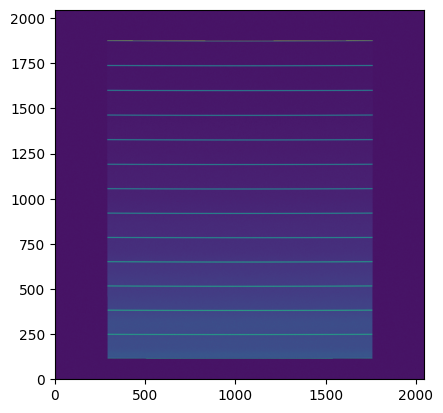

In [8]:
plt.imshow(readout[1].data, origin="lower");

## Rectification of the spectrum

The non-linearity in the dispersion in METIS is small and not readily apparent.Still, rectification is necessary to arrive at a 2D spectrum with well-defined wavelength and spatial coordinates. The method to use is `rectify_traces` and belongs to the `SpectralTraceList` effect, which is accessible in the METIS `OpticalTrain` as `"spectral_traces"` (in MICADO it would be `"micado_spectral_traces"`. Currently, it is necessary to specify the spatial extent of the slit when calling the method. The long slit in METIS has a length of 8 arcsec and extends from -4 arcsec to +4 arcsec.

In [9]:
tracelist = metis["spectral_traces"]

In [10]:
rectified = tracelist.rectify_traces(readout, -4.0, 4.0)

astar.scopesim.effects.spectral_trace_list - Full wavelength range: 2.79 .. 4.39 um
astar.scopesim.effects.spectral_trace_list - Computing interpolation functions


 Traces:   0%|          | 0/1 [00:00<?, ?it/s]

astar.scopesim.effects.spectral_trace_list_utils - Rectifying METIS LSS L
astar.scopesim.effects.spectral_trace_list_utils -    2.90 .. 4.20 um
astar.scopesim.effects.spectral_trace_list_utils -    Bin width 0.00072 um


`rectified` is a HDU list with one extension for each spectral trace - for METIS there's only one trace, for MICADO there would be several. Each extension has a WCS that translates pixel coordinates into wavelength and position along the slit.

In [11]:
wcs = WCS(rectified[1])
naxis1 = rectified[1].header["NAXIS1"]
naxis2 = rectified[1].header["NAXIS2"]

In [12]:
lam = (wcs.all_pix2world(np.arange(naxis1), 800, 0)[0] * u.Unit(wcs.wcs.cunit[0])).to(u.um).value
xi = (wcs.all_pix2world(1000, np.arange(naxis2), 0)[1] * u.Unit(wcs.wcs.cunit[1])).to(u.arcsec).value

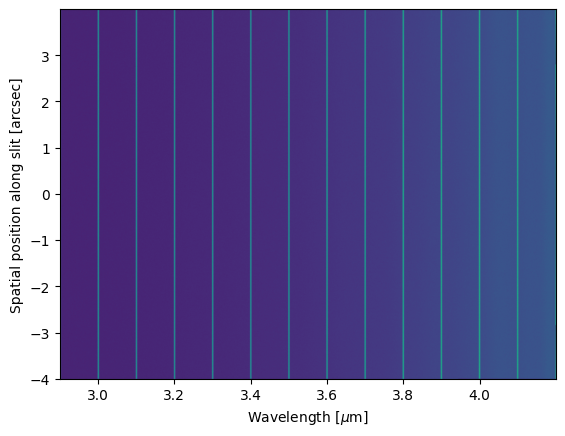

In [13]:
plt.imshow(rectified[1].data, origin="lower", extent=[lam[0], lam[-1], xi[0], xi[-1]])
plt.gca().set_aspect("auto")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel(r"Spatial position along slit [arcsec]");

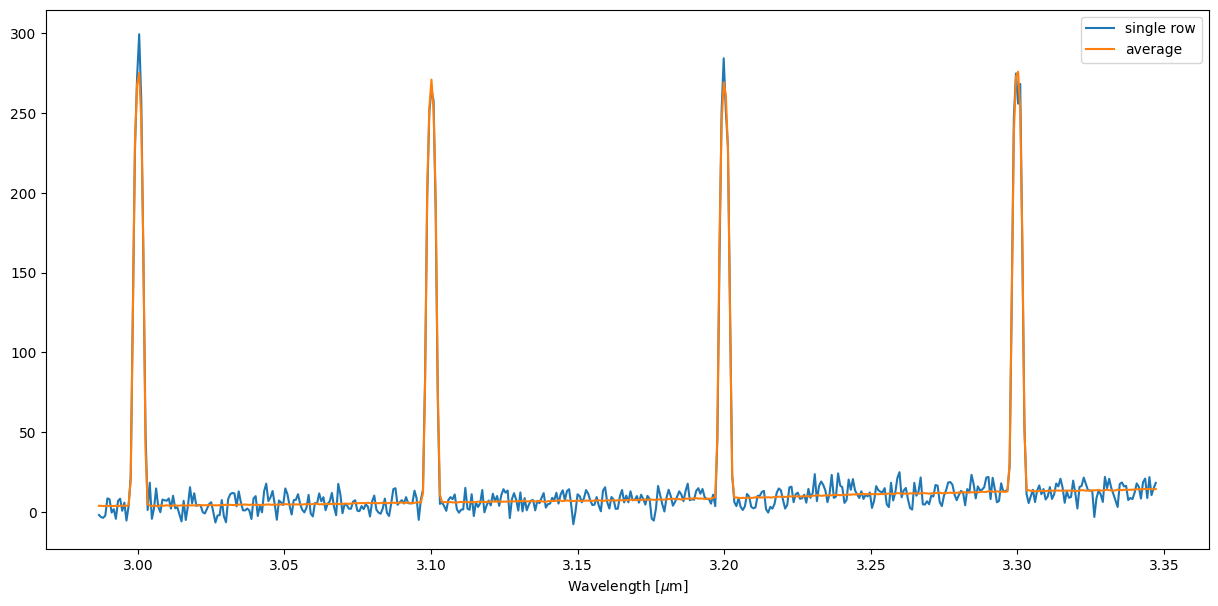

In [14]:
i1, i2 = 120, 620
plt.figure(figsize=(15, 7))
plt.plot(lam[i1:i2], rectified[1].data[800, i1:i2], label="single row")
plt.plot(lam[i1:i2], rectified[1].data.mean(axis=0)[i1:i2], label="average")
plt.legend()
plt.xlabel(r"Wavelength [$\mu$m]");